## Telecom User Data Analysis

### Libraries

In [28]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from statistics import mean
from pandas_profiling import ProfileReport
import numpy as np

### Data Preprocessing

In [2]:
df = pd.read_excel("../data/telcom.xlsx",engine='openpyxl')

In [118]:
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,13114483460844900352,2019-04-04 12:01:18,770.0,2019-04-25 14:35:31,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9164566995485190,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,13114483482878900224,2019-04-09 13:04:04,235.0,2019-04-25 08:15:48,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,13114483484080500736,2019-04-09 17:42:11,1.0,2019-04-25 11:58:13,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,13114483485442799616,2019-04-10 00:31:25,486.0,2019-04-25 07:36:35,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,13114483499480700928,2019-04-12 20:10:23,565.0,2019-04-25 10:40:32,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [6]:
### Check for sufficiency of data to answer objectives by reviewing the objective and 
### available data. And check the number of observations and required sample size.

In [119]:
df.columns.to_list()

['Bearer Id',
 'Start',
 'Start ms',
 'End',
 'End ms',
 'Dur. (ms)',
 'IMSI',
 'MSISDN/Number',
 'IMEI',
 'Last Location Name',
 'Avg RTT DL (ms)',
 'Avg RTT UL (ms)',
 'Avg Bearer TP DL (kbps)',
 'Avg Bearer TP UL (kbps)',
 'TCP DL Retrans. Vol (Bytes)',
 'TCP UL Retrans. Vol (Bytes)',
 'DL TP < 50 Kbps (%)',
 '50 Kbps < DL TP < 250 Kbps (%)',
 '250 Kbps < DL TP < 1 Mbps (%)',
 'DL TP > 1 Mbps (%)',
 'UL TP < 10 Kbps (%)',
 '10 Kbps < UL TP < 50 Kbps (%)',
 '50 Kbps < UL TP < 300 Kbps (%)',
 'UL TP > 300 Kbps (%)',
 'HTTP DL (Bytes)',
 'HTTP UL (Bytes)',
 'Activity Duration DL (ms)',
 'Activity Duration UL (ms)',
 'Dur. (ms).1',
 'Handset Manufacturer',
 'Handset Type',
 'Nb of sec with 125000B < Vol DL',
 'Nb of sec with 1250B < Vol UL < 6250B',
 'Nb of sec with 31250B < Vol DL < 125000B',
 'Nb of sec with 37500B < Vol UL',
 'Nb of sec with 6250B < Vol DL < 31250B',
 'Nb of sec with 6250B < Vol UL < 37500B',
 'Nb of sec with Vol DL < 6250B',
 'Nb of sec with Vol UL < 1250B',
 'Socia

In [120]:
df.shape

(150001, 55)

In [12]:
### Check for timeliness of the data

In [10]:
### checking for duplicates

In [13]:
### Check for column organization and naming and correct them.

In [59]:
### Check for missing values and either fill them with a value that will, in no way, 
### affect the analysis or remove the record.

In [21]:
def handle_missing_values(df,x):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mean
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    null_cols = df.isnull().sum().to_dict()
    for key,val in null_cols.items():
        if val/df.shape[0] > x:
            df.drop([key], axis=1)
        elif  val/df.shape[0] < x and val > 0 and df[key].dtype.kind in 'biufc':
            df.fillna(df[key].mean().round(1), inplace=True)
    return missing_percentage, df

In [26]:
# test the function
missing_percentage,df_ = handle_missing_values(df,x=0.3)
True in df.isna().any().to_list()

False

In [24]:
df_.isnull().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [25]:
df_.shape

(150001, 55)

In [15]:
### Check for misspellings, Inconsistent capitalization, and Incorrect punctuation and other typos and 
### make corrections.

In [16]:
### Check for correct character patterns like length and type of characters and make corrections.

In [17]:
### Check for values that don't make sense given knowledge of the field and make corrections.

In [18]:
### Check for value ranges and make corrections.

In [167]:
### Check for repeating or skipping patterns in variables whose values must be in sequence 
### or whose values must be unique and make corrections

In [168]:
### Top X Columns

In [164]:
def top_x_column(df, x, column,color):
    handsets_df = pd.DataFrame(columns = [column])
    handsets_df['type'] = df[column].to_list()
    handests = handsets_df['type'].value_counts()
    fig,ax = plt.subplots()
    ax.tick_params(axis='x',labelsize=10)
    ax.tick_params(axis='y',labelsize=10)
    ax.set_xlabel("Handset")
    ax.set_ylabel("Frequency")
    ax.set_title(f"The {x} Most Frequent {column}")
    handests[:x].plot(ax=ax,kind='bar',color=color)

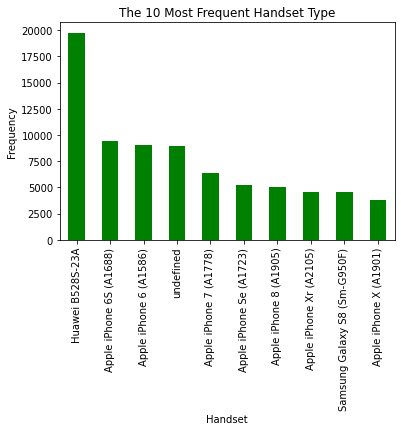

In [165]:
# Identifying the top 10 handsets used by the customers.
top_x_column(df,10,'Handset Type','green')

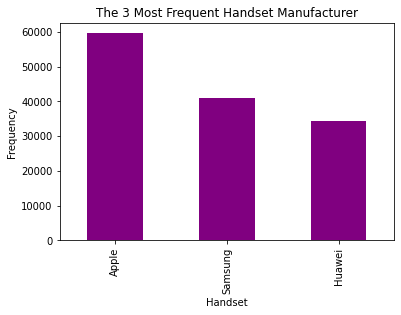

In [166]:
# Identifying the top 3 handset manufacturers
top_x_column(df,3,'Handset Manufacturer','purple')

In [196]:
# Identify the top 5 handsets per top 3 handset manufacturer
by_manufacture = df.groupby("Handset Manufacturer",sort=True)

for manufacturer, frame in by_manufacture:
    if manufacturer in ['Apple','Samsung','Huawei']:
        print(f"First 5 entries for {manufacturer!r}")
        print("------------------------")
        print(frame.head(5)['Handset Type'], end="\n\n")


First 5 entries for 'Apple'
------------------------
22    Apple iPhone 6S (A1688)
48    Apple iPhone 6S (A1688)
51    Apple iPhone Se (A1723)
52     Apple iPhone 8 (A1905)
54    Apple iPhone 6S (A1688)
Name: Handset Type, dtype: object

First 5 entries for 'Huawei'
------------------------
6     Huawei Mate 20 Lite
11        Huawei B593S-22
20           Huawei E5180
25         Huawei P20 Pro
30           Huawei E5180
Name: Handset Type, dtype: object

First 5 entries for 'Samsung'
------------------------
0     Samsung Galaxy A5 Sm-A520F
1    Samsung Galaxy J5 (Sm-J530)
2       Samsung Galaxy A8 (2018)
4               Samsung Sm-G390F
8       Samsung Galaxy A8 (2018)
Name: Handset Type, dtype: object



In [197]:
df.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [20]:
# Aggregation per user the following information in the column  
# number of xDR sessions
# Session duration
# the total download (DL) and upload (UL) data
# the total data volume (in Bytes) during this session for each application


In [37]:
grouped = df.groupby('MSISDN/Number').agg({'Bearer Id': [min, max, mean]}) 
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

In [38]:
grouped

,Bearer Id_min,Bearer Id_max,Bearer Id_mean
MSISDN/Number,,,
3.360100e+10,1.311448e+19,1.311448e+19,1.311448e+19
3.360100e+10,7.349883e+18,7.349883e+18,7.349883e+18
3.360100e+10,7.349883e+18,7.349883e+18,7.349883e+18
3.360101e+10,1.304243e+19,1.304243e+19,1.304243e+19
3.360101e+10,7.277826e+18,7.349883e+18,7.313854e+18
...,...,...,...
3.379000e+10,1.311448e+19,1.311448e+19,1.311448e+19
3.197021e+12,7.277826e+18,7.277826e+18,7.277826e+18
3.370000e+14,7.349883e+18,7.349883e+18,7.349883e+18


In [35]:
grouped = df.groupby('MSISDN/Number').agg({"Dur. (ms)": [min, max, mean]}) 
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

In [36]:
grouped

,Dur. (ms)_min,Dur. (ms)_max,Dur. (ms)_mean
MSISDN/Number,,,
3.360100e+10,116720.0,1.167200e+05,1.167200e+05
3.360100e+10,181230.0,1.812300e+05,1.812300e+05
3.360100e+10,134969.0,1.349690e+05,1.349690e+05
3.360101e+10,49878.0,4.987800e+04,4.987800e+04
3.360101e+10,18549.0,1.855500e+04,1.855200e+04
...,...,...,...
3.379000e+10,140988.0,1.409880e+05,1.409880e+05
3.197021e+12,877385.0,8.773850e+05,8.773850e+05
3.370000e+14,253030.0,2.530300e+05,2.530300e+05


In [39]:
grouped = df.groupby('MSISDN/Number').agg({'Total DL (Bytes)': [min, max, mean]}) 
grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]

In [44]:
grouped

,Total DL (Bytes)_min,Total DL (Bytes)_max,Total DL (Bytes)_mean
MSISDN/Number,,,
3.360100e+10,842637466.0,8.426375e+08,8.426375e+08
3.360100e+10,120755184.0,1.207552e+08,1.207552e+08
3.360100e+10,556659663.0,5.566597e+08,5.566597e+08
3.360101e+10,401993172.0,4.019932e+08,4.019932e+08
3.360101e+10,547096937.0,8.160335e+08,6.815652e+08
...,...,...,...
3.379000e+10,444575092.0,4.445751e+08,4.445751e+08
3.197021e+12,194828056.0,1.948281e+08,1.948281e+08
3.370000e+14,539634985.0,5.396350e+08,5.396350e+08


## EDA Analysis

In [50]:
X = df.drop('Total DL (Bytes)', axis=1)
y = df['Total DL (Bytes)']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5, 
                                                random_state=1121218)

In [51]:
pca_1 = pd.concat([X_valid,y_valid])

In [38]:
pca_1.shape

(90002, 55)

In [39]:
#### pca analysis
pca_2 = pd.concat([X_train,y_train])

In [48]:
pca_2.shape

(210000, 55)

In [47]:
all_samples = np.concatenate((pca_1, pca_2), axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 90002 and the array at index 1 has size 210000

In [ ]:
all

In [41]:
mean_pca_1 = np.mean(pca_1)

In [42]:
mean_pca_2 = np.mean(pca_2)

In [43]:
mean_vector = np.array([[mean_pca_1],[mean_pca_2]])

In [45]:
mean_vector

array([[[4.54314093e+08, 7.80386463e-01, 1.70925711e+00, 3.03658591e+00,
         1.43862392e-01, 1.86436777e+06, 1.44717723e+06, 1.31906262e+04,
         1.75881945e+03, 1.12682785e+02, 1.75982522e+01, 9.28906222e+01,
         1.60066154e+00, 1.04060418e+05, 1.04060963e+08, 1.79172149e+06,
         4.66493195e+05, 4.98082509e+02, 4.21784472e+08, 8.26008113e+06,
         5.74381744e+06, 2.05149270e+06, 1.16111750e+08, 3.20531457e+06,
         4.86603941e+13, 2.08201568e+14, 3.37452295e+10, 1.00592438e+03,
         3.47955878e+02, 8.19413338e+02, 1.42617543e+02, 9.63856982e+02,
         1.38227559e+02, 3.80115548e+03, 4.10780943e+03, 1.16064894e+07,
         1.10083306e+07, 4.21318000e+08, 8.28134796e+06, 1.79744357e+06,
         3.29894349e+04, 4.98263416e+02, 2.18444300e+07, 9.62036725e+05,
         4.11357423e+07, 9.85290964e+01, 8.08220708e-02, 1.15901488e+07,
         1.10350072e+07]],

       [[4.54784579e+08, 7.75190533e-01, 1.72080227e+00, 3.08338517e+00,
         1.49754893e-01

In [46]:
scatter_matrix = np.zeros((2,2))

In [ ]:
for i in range(all_samples.shape[1]):
    scatter_matrix += (all_samples[:,i].reshape(2,1) - mean_vector).dot((all_samples[:,i].reshape(2,1) - mean_vector).T)
print('Scatter Matrix:\n', scatter_matrix)

In [ ]:
report = ProfileReport(report_df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
report.to_file("report.html")

In [8]:
## scaling and normalizing of the dataset

In [11]:
numerical_features = df.select_dtypes(include='number').columns.tolist()

In [10]:
categorical_features = df.select_dtypes(exclude='number').columns.to_list()

In [14]:
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [17]:
preprocessed_data = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

In [19]:
numerical_transforms = numeric_pipeline.fit_transform(df.select_dtypes(include='number'))

In [20]:
numerical_transforms

array([[0.98850572, 0.77077077, 0.66266266, ..., 0.53230399, 0.44899105,
        0.33684625],
       [0.98850572, 0.23523524, 0.60660661, ..., 0.90919131, 0.67493396,
        0.72140079],
       [0.98850572, 0.001001  , 0.65265265, ..., 0.2545866 , 0.33150386,
        0.30439426],
       ...,
       [0.98850573, 0.28328328, 0.81081081, ..., 0.68330261, 0.4246416 ,
        0.65375757],
       [0.98850573, 0.6966967 , 0.32732733, ..., 0.08495744, 0.35459365,
        0.40718827],
       [0.51385153, 0.49968789, 0.49930018, ..., 0.4991133 , 0.50691856,
        0.49955529]])

In [ ]:
preped_data